In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import scipy
from scipy.interpolate import griddata
import geopandas
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import nctoolkit 
import os
import glob
from datetime import datetime
from dateutil import tz
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import geopandas as gpd
from shapely.geometry import Polygon
import pyproj
from pyproj import CRS
from metpy.units import units

nctoolkit is using Climate Data Operators version 2.1.1


In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

# Open bathymetry to mask

In [3]:
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))

# Open H8 dataset

In [4]:
import xarray
import pyproj
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy

In [5]:
source_proj = pyproj.Proj(proj='latlong', a=6378137, b=6356752.3)

# Define the extent and resolution of the target grid
lon_min, lon_max = 140, 155
lat_min, lat_max = -22, -12
resolution = 0.18

# Create latitude and longitude arrays for the target grid
target_lats = np.arange(lat_min, lat_max + resolution, resolution)
target_lons = np.arange(lon_min, lon_max + resolution, resolution)

In [6]:
# Define the target projection using cartopy
target_proj = ccrs.PlateCarree()

# Create a grid of coordinates to reproject
X, Y = np.meshgrid(target_lons, target_lats)

# Reproject the coordinates from the source projection to the target projection
lon, lat = pyproj.transform(source_proj, target_proj, X, Y)

In [7]:
ds = xr.open_dataset('/g/data/gy85/Himawari8_AusGeo1-0-3/L1/summer_2015-2016/201601/geocatL1.HIMAWARI-8.2016001.000000.FLDK.R20.nc', chunks={'x': 1000, 'y': 1000})

original_lats = ds.pixel_latitude.values  # Latitude values
lats_reshape = original_lats.reshape(30250000 )
lats_reshape[np.isnan(lats_reshape)] = 0    
original_lons = ds.pixel_longitude.values  # Longitude values
lons_reshape = original_lons.reshape(30250000 )
lons_reshape[np.isnan(lons_reshape)] = 0    
ch13bt_data = ds['himawari_8_ahi_channel_13_brightness_temperature'].values 
ch13bt_reshape = ch13bt_data.reshape(30250000 ) 
ch13bt_reshape[np.isnan(ch13bt_reshape)] = 0    
# reproj_grid = np.column_stack([reprojected_coords[1].ravel(), reprojected_coords[0].ravel()])

interpolated_data = griddata(
    (lons_reshape, lats_reshape),  # Original data coordinates
    ch13bt_reshape,                    # Data values to interpolate
    (lon, lat),  # Target grid coordinates
    method='nearest'  # Interpolation method (e.g., 'linear', 'cubic', 'nearest')
)

In [84]:
# Convert the latitude and longitude grids to 1D arrays
latitudes = lat.ravel()
longitudes = lon.ravel()
ch13BT = interpolated_data.ravel()

# Create DataArray for latitude
latitudes_da = xr.DataArray(latitudes, dims='index')
# Create DataArray for longitude
longitudes_da = xr.DataArray(longitudes, dims='index')
# Create DataArray for data variable
ch13BT_values_da = xr.DataArray(ch13BT, dims='index')
# create xarray dataset
ch13BT_ = xr.Dataset({'ch13BT': ch13BT_values_da}) #'lat': latitudes_da, 'lon': longitudes_da,
# Assign coordinates for latitude and longitude
ch13BT_ds = ch13BT_.assign_coords(lat=latitudes_da, lon=longitudes_da)

# # Create a DataFrame
# ch13_df = pd.DataFrame({
#     'lat': latitudes,
#     'lon': longitudes,
#     'ch13BT': ch13BT
# })

array([[282.84952, 290.99612, 283.37137, ..., 295.40176, 295.32486,
        294.91287],
       [282.9374 , 281.73712, 284.26404, ..., 294.91287, 295.27267,
        295.34958],
       [280.91037, 282.79184, 293.74554, ..., 294.83597, 295.32486,
        295.37704],
       ...,
       [295.11887, 294.91287, 267.6577 , ..., 289.97162, 295.65723,
        297.4618 ],
       [293.87463, 296.65152, 275.87573, ..., 297.10745, 296.9564 ,
        297.15964],
       [292.90506, 297.00858, 294.9376 , ..., 295.94012, 292.03436,
        289.29318]], dtype=float32)

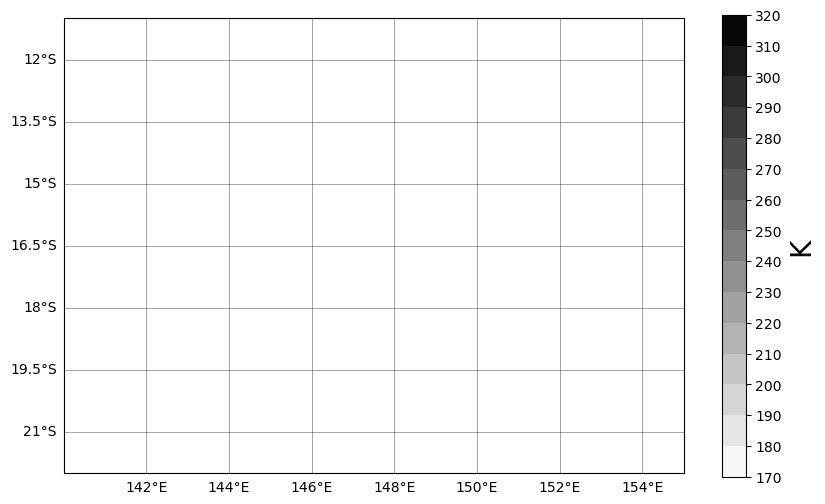

In [80]:
min_lat = -20.77
max_lat = -18.07
towns_domain = ch13_df[(ch13_df['lat'] <= max_lat) & (ch13_df['lat'] >= -20.77)] 
# ch13_df.plot()

fig = plt.figure(1, figsize=[10,6])
fig.patch.set_facecolor('white')
ax = plt.axes(projection=ccrs.PlateCarree())
levels = [170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320]
cs = ax.contourf((ch13BT_ds['lon']* units('degree'),ch13BT_ds['lat']* units('degree')),ch13BT_ds.ch13BT,levels=levels,cmap="binary") #willis
cbar = plt.colorbar(cs,aspect=20,orientation='vertical',ax=ax,
                    ticks=[170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320])
cbar.set_label('K',fontsize=20) 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='black', alpha=0.5, linestyle='-')
gl.top_labels = False
gl.right_labels = False
ax.set_xlim(140,155)
ax.set_ylim(-22,-11)
ax.coastlines(color="white");

# pyproj

In [108]:
times=hours_fp[0]
data = xr.open_dataset('/g/data/gy85/Himawari8_AusGeo1-0-3/L1/summer_2015-2016/201601/geocatL1.HIMAWARI-8.2016001.000000.FLDK.R20.nc', chunks={'x': 1000, 'y': 1000})
subset = data.isel(lines=slice(1000, 3000), elements=slice(1000, 4200))
# subset.himawari_8_ahi_channel_13_brightness_temperature.plot()
source_crs = CRS.from_proj4("+proj=latlong +lat_ts=23.08965302 +lat_0=-51.41923523 +lon_0=59.303939820000004 +x_0=0 +y_0=0 +a=6378.137 +b=6356.7523 +units=km +datum=WGS84 +type=crs")  # Coordinate system of the file
target_crs = 'epsg:4326' # Global lat-lon coordinate system
geo_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
X, Y = numpy.meshgrid(subset.elements, subset.lines)
lat, lon = geo_to_latlon.transform(X, Y)

In [113]:
subset.coords['lat'] = (subset.himawari_8_ahi_channel_13_brightness_temperature.dims, lat)
subset.coords['lon'] = (subset.himawari_8_ahi_channel_13_brightness_temperature.dims, lon)
subset.himawari_8_ahi_channel_13_brightness_temperature

<xarray.DataArray 'himawari_8_ahi_channel_13_brightness_temperature' (
                                                                      lines: 2000,
                                                                      elements: 3200)>
dask.array<getitem, shape=(2000, 3200), dtype=float32, chunksize=(2000, 3200), chunktype=numpy.ndarray>
Coordinates:
    lat      (lines, elements) float64 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
    lon      (lines, elements) float64 59.3 60.3 61.3 ... -163.7 -162.7 -161.7
Dimensions without coordinates: lines, elements
Attributes:
    reference:          all data are referenced to the instrument-native chan...
    algorithm_index:    32
    valid_range:        [-32767  32767]
    algorithm_name:     NA
    long_name:          pixel-resolution array of brightness temperatures for...
    valid_min:          -32767
    units:              K
    scaling_method:     1
    valid_max:          32767
    algorithm_version:  NA
    standard_name:      brightness_temperature

In [ ]:
# crs = CRS.from_proj4("+proj=latlong +lat_ts=-22 +lat_0=-12 +lon_0=147.5 +x_0=0 +y_0=0 +a=6378.137 +b=6356.7523 +units=km")
# LongitudeW = 140 
# LongitudeE = 155
# LatitudeS = -22
# LatitudeN = -12
times=hours_fp[0]
ds = xr.open_dataset(times[0],engine="h5netcdf") 
proj = pyproj.Proj('+proj=latlong +a=6378.137 +b=6356.7523 +units=km') 
lon, lat = proj(ds.pixel_longitude, ds.pixel_latitude, inverse=False)
# himawari_8_ahi_channel_13_brightness_temperature


# original

In [4]:
from collections import defaultdict
def list_files_in_directory(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nc"):  # Check for the ".nc" file extension
                file_paths.append(os.path.join(root, file))
    return file_paths
directory = "/g/data/gy85/Himawari8_AusGeo1-0-3/L1/"
file_paths = list_files_in_directory(directory)
file_paths.sort()

hour_filenames = {}  # Dictionary to store lists of file names for each unique hour
for file_hour in file_paths:
    fn = os.path.basename(file_hour)
    hour = fn[28:30]  # Extract the hour information from the file name
    # Check if the hour is already in the dictionary, if not, create a new list
    if hour not in hour_filenames:
        hour_filenames[hour] = []
    # Append the file name to the list associated with that hour
    hour_filenames[hour].append(file_hour)

# Convert the dictionary values (lists of file names) to lists
hourly_file_lists = list(hour_filenames.values())

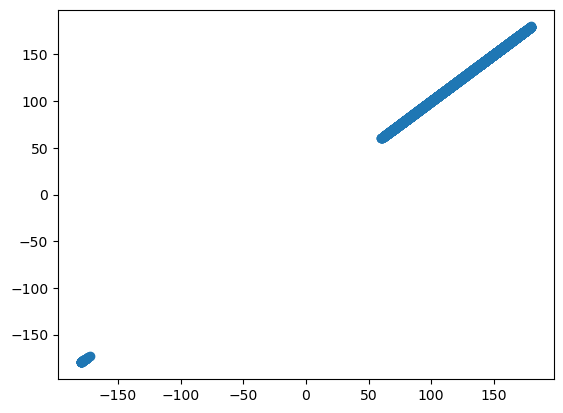

In [38]:
from numpy import s_

times=hourly_file_lists[0]
times5=hourly_file_lists[10]
ds=xr.open_dataset(times[0], engine="h5netcdf").isel(elements=s_[::20], lines=s_[::20])
ds5=xr.open_dataset(times5[100], engine="h5netcdf").isel(elements=s_[::20], lines=s_[::20])
# plt.scatter(ds["pixel_longitude"], ds["pixel_latitude"], s=0.01)
plt.scatter(ds.pixel_longitude.values,ds5.pixel_longitude.values);

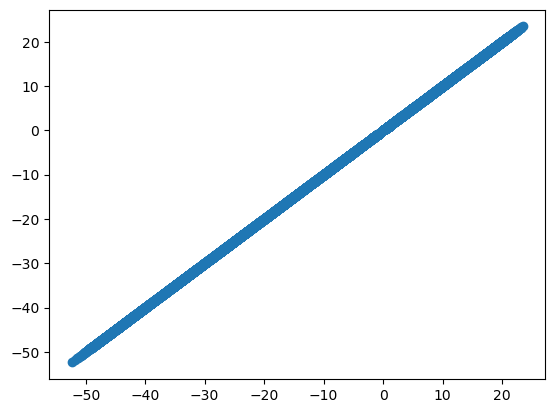

In [39]:
plt.scatter(ds.pixel_latitude.values,ds5.pixel_latitude.values);

In [230]:
# define function to interpolate BT data onto a lat lon meshgrid
def produce_BT_griddata(files):
    BT_data_T_land = []
    BT_data_T_ocean = []
    BT_data_C_land = []
    BT_data_C_ocean = []
    BT_data_W = []
    for file in files:
        with xr.open_dataset(file, engine="h5netcdf") as ds:     
            fn = os.path.basename(file).split('/')[-1] # extract file name
        
    #assign file variable contents to python variables and reshape
            ch13bt_data = ds['himawari_8_ahi_channel_13_brightness_temperature'][1500:2300,2500:3500].values 
            ch13bt_reshape = ch13bt_data.reshape(800000) 
            ch13bt_reshape[np.isnan(ch13bt_reshape)] = 0    
            lon2d = ds['pixel_longitude'][1500:2300,2500:3500].values
            lon1d = lon2d.reshape(800000)
            lon1d[np.isnan(lon1d)] = 0
            lat2d = ds['pixel_latitude'][1500:2300,2500:3500].values 
            lat1d = lat2d.reshape(800000)
            lat1d[np.isnan(lat1d)] = 0
    
    # create meshgrid for interpolation
            res = 0.05 
            grid_x = np.arange(140, 155, res)
            grid_y = np.arange(-22, -11, res)
            grid_y = np.flipud(grid_y)
            xi,yi = np.meshgrid(grid_x,grid_y)
    # interpolate channel 13 brightness temperature values onto x,y grid
            BTD = griddata((lon1d,lat1d), ch13bt_reshape, (xi, yi), method='nearest') ##### returns= CTP[lat:lon]    
        
        # To access a specific interpolated value at a grid point (i, j)
        # value_at_xy = BTD[x, y]
        # To access all values for a specific latitude
        # row_of_values = BTD[x, :]
        # To access all values for a specific longitude
        # column_of_values = BTD[:, y]
        # To access a subregion of interpolated values (a slice of the meshgrid) [start_x:end_x, start_y:end_y]
            townsville_domain = BTD[140:194,100:160]
            cairns_domain = BTD[88:144,85:143]
            willis_domain = BTD[77:133,171:229]
        # mask ocean and land
            bathymetryT = ds_bath["z"].sel(x=xi[140:194,100:160].values,y=yi[140:194,100:160].values,method="nearest")
            bathymetryC = ds_bath["z"].sel(x=xi[88:144,85:143],y=yi[88:144,85:143],method="nearest")
            bathymetry_ocean_maskT = bathymetryT<= 0 
            bathymetry_ocean_maskC = bathymetryC<= 0 
            bathymetry_land_maskT = bathymetryT> 0
            bathymetry_land_maskC = bathymetryC> 0
            towns_land_mask = xr.where(bathymetry_land_maskT, np.nan, townsville_domain)
            towns_ocean_mask = xr.where(bathymetry_ocean_maskT, np.nan, townsville_domain)
            cairns_land_mask = xr.where(bathymetry_land_maskC, np.nan, cairns_domain)
            cairns_ocean_mask = xr.where(bathymetry_ocean_maskC, np.nan, cairns_domain)
            
            BT_data_T_land.append(towns_ocean_mask) # townsville ~radar domain
            BT_data_T_ocean.append(towns_land_mask)
            BT_data_C_land.append(cairns_ocean_mask)
            BT_data_C_ocean.append(cairns_land_mask)
            BT_data_W.append(willis_domain)  
            print(fn[20:32])
    return BT_data_T_land,BT_data_T_ocean,BT_data_C_land,BT_data_C_ocean,BT_data_W

In [231]:
%%time
times=hourly_file_lists[0]
ch13bt_towns_land,ch13bt_towns_ocean,ch13bt_cairns_land,ch13bt_cairns_ocean,ch13bt_willis = produce_BT_griddata(times[0:10])

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [176]:
%%time
towns_btd = []
cairns_btd = [] 
willis_btd = []
for hour in np.arange(0,24,1):
    ch13bt_towns,ch13bt_cairns,ch13bt_willis = produce_BT_griddata(hourly_file_lists[hour])
    
    # bathymetry = ds_bath["z"].sel(x=xi,y=yi,method="nearest")
    # bathymetry_mask = bathymetry<= 0 
    # masked_btdT = xr.where(bathymetry_mask, np.nan, BTD[140:194,100:160])
    
    meanT = np.mean(ch13bt_towns)
    towns_btd.append(meanT)
    print('towns')
    meanC = np.mean(ch13bt_cairns)
    cairns_btd.append(meanC)
    print('cairns')
    meanW = np.mean(ch13bt_willis)
    willis_btd.append(meanW)

2015305.0000
2015306.0000
2015307.0000
2015308.0000
2015309.0000
2015310.0000
2015311.0000
2015312.0000
2015313.0000
2015314.0000
2015315.0000
2015316.0000
2015317.0000
2015318.0000
2015319.0000
2015320.0000
2015321.0000
2015322.0000
2015323.0000
2015324.0000
2015325.0000
2015326.0000
2015327.0000
2015328.0000
2015329.0000
2015330.0000
2015331.0000
2015332.0000
2015333.0000
2015334.0000
2015335.0000
2015336.0000
2015337.0000
2015338.0000
2015339.0000
2015340.0000
2015341.0000
2015342.0000
2015343.0000
2015344.0000
2015345.0000
2015346.0000
2015347.0000
2015348.0000
2015349.0000
2015350.0000
2015351.0000
2015352.0000
2015353.0000
2015354.0000
2015355.0000
2015356.0000
2015357.0000
2015358.0000
2015359.0000
2015360.0000
2015361.0000
2015362.0000
2015363.0000
2015364.0000
2015365.0000
2016001.0000
2016002.0000
2016003.0000
2016004.0000
2016005.0000
2016006.0000
2016007.0000
2016008.0000
2016009.0000
2016010.0000
2016011.0000
2016012.0000
2016013.0000
2016014.0000
2016015.0000
2016016.0000

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2018025.1400
2018026.1400
2018027.1400
2018028.1400
2018029.1400
2018030.1400
2018031.1400
2018032.1400
2018033.1400
2018034.1400
2018035.1400
2018036.1400
2018037.1400
2018038.1400
2018039.1400
2018040.1400
2018041.1400
2018042.1400
2018043.1400
2018045.1400
2018046.1400
2018047.1400
2018048.1400
2018049.1400
2018050.1400
2018051.1400
2018052.1400
2018053.1400
2018054.1400
2018055.1400
2018056.1400
2018057.1400
2018058.1400
2018059.1400
2018060.1400
2018061.1400
2018062.1400
2018063.1400
2018064.1400
2018065.1400
2018066.1400
2018067.1400
2018068.1400
2018069.1400
2018070.1400
2018071.1400
2018072.1400
2018073.1400
2018074.1400
2018075.1400
2018076.1400
2018077.1400
2018080.1400
2018081.1400
2018082.1400
2018083.1400
2018084.1400
2018085.1400
2018086.1400
2018087.1400
2018088.1400
2018090.1400
2018305.1400
2018306.1400
2018307.1400
2018308.1400
2018309.1400
2018310.1400
2018311.1400
2018312.1400
2018313.1400
2018314.1400
2018315.1400
2018316.1400
2018317.1400
2018318.1400
2018319.1400

In [182]:
meanT_AEST = np.roll(towns_btd, shift=10)
meanC_AEST = np.roll(cairns_btd, shift=10)
meanW_AEST = np.roll(willis_btd, shift=10)

In [180]:
towns_btd

[289.9166,
 291.09857,
 291.54587,
 291.05756,
 289.62253,
 287.7398,
 285.7523,
 284.08502,
 282.43887,
 281.3752,
 280.88007,
 280.6989,
 280.70145,
 280.6087,
 280.43784,
 280.3079,
 280.32492,
 280.70883,
 281.1464,
 281.89172,
 282.53482,
 284.47552,
 286.23376,
 288.20242]

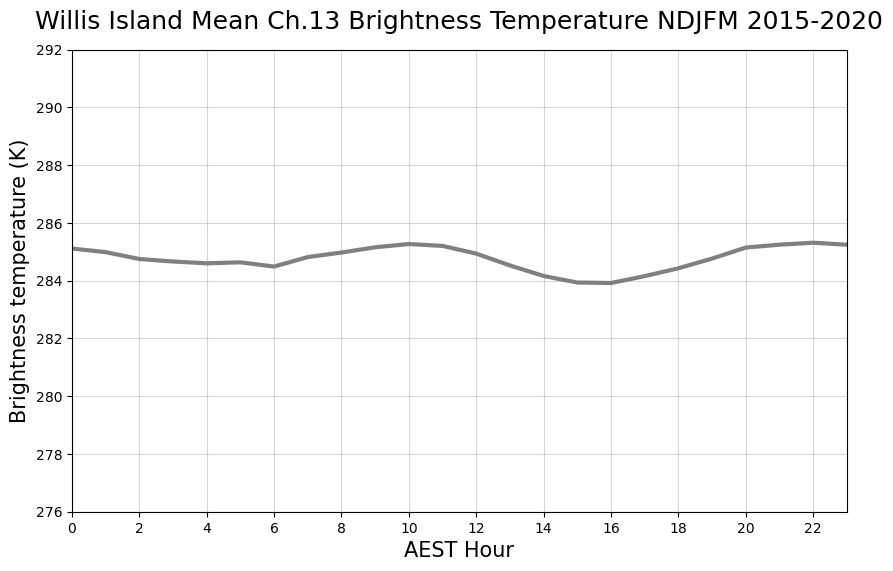

In [205]:
fig,ax = plt.subplots(1,1, figsize=[10,6])
fig.patch.set_facecolor('white')
# plt.plot(np.arange(0,24,1),meanT_AEST,color="grey",linewidth=3)#,label='Townsville')
# plt.plot(np.arange(0,24,1),meanC_AEST,color="grey",linewidth=3)#,label='Cairns')
plt.plot(np.arange(0,24,1),meanW_AEST,color="grey",linewidth=3)#,label='Willis Island')
# plt.legend()
plt.xlim(0,23)
plt.title("Willis Island Mean Ch.13 Brightness Temperature NDJFM 2015-2020",fontsize=18,pad=15)
plt.xlabel("AEST Hour",fontsize=15)
plt.xticks(np.arange(0,24,2))
plt.ylabel("Brightness temperature (K)",fontsize=15)
plt.ylim(276,292)
plt.grid(alpha=0.5)

# Plot snapshot plots

In [215]:
times = hourly_file_lists[10]
ds = xr.open_dataset(times[0],engine="h5netcdf")
ch13bt_data = ds['himawari_8_ahi_channel_13_brightness_temperature'][1500:2300,2500:3500].values #[lat,lon]
ch13bt_reshape = ch13bt_data.reshape(800000) 
ch13bt_reshape[np.isnan(ch13bt_reshape)] = 0    
lon2d = ds['pixel_longitude'][1500:2300,2500:3500].values
lon1d = lon2d.reshape(800000)
lon1d[np.isnan(lon1d)] = 0
lat2d = ds['pixel_latitude'][1500:2300,2500:3500].values 
lat1d = lat2d.reshape(800000)
lat1d[np.isnan(lat1d)] = 0
    
    # create meshgrid for interpolation
        # radar townsville: (-20.768799,-18.0708,145.12054,147.9812)
res = 0.05 #0.18
grid_x = np.arange(140, 155, res)#154, res) towns:(145,147)
grid_y = np.arange(-22, -11, res)#-22, -11, res) towns:(-20.77,-18.07)
grid_y = np.flipud(grid_y)
xi,yi = np.meshgrid(grid_x,grid_y)
    # interpolate channel 13 brightness temperature values onto x,y grid
BTD = griddata((lon1d,lat1d), ch13bt_reshape, (xi, yi), method='nearest')

# # create meshgrid for interpolation
# res = 0.1 #0.18
# grid_x = np.arange(140, 154, res)#154, res)
# grid_y = np.arange(-22, -10, res)#-22, -11, res)
# grid_y = np.flipud(grid_y)
# xi,yi = np.meshgrid(grid_x,grid_y)

# # interpolate channel 13 brightness temperature values onto x,y grid
# CTP = griddata((lon1d,lat1d), ch13bt_reshape, (xi, yi), method='nearest') ##### return= CTP[lat:lon]    

array([[148.55, 148.6 , 148.65, ..., 151.3 , 151.35, 151.4 ],
       [148.55, 148.6 , 148.65, ..., 151.3 , 151.35, 151.4 ],
       [148.55, 148.6 , 148.65, ..., 151.3 , 151.35, 151.4 ],
       ...,
       [148.55, 148.6 , 148.65, ..., 151.3 , 151.35, 151.4 ],
       [148.55, 148.6 , 148.65, ..., 151.3 , 151.35, 151.4 ],
       [148.55, 148.6 , 148.65, ..., 151.3 , 151.35, 151.4 ]])

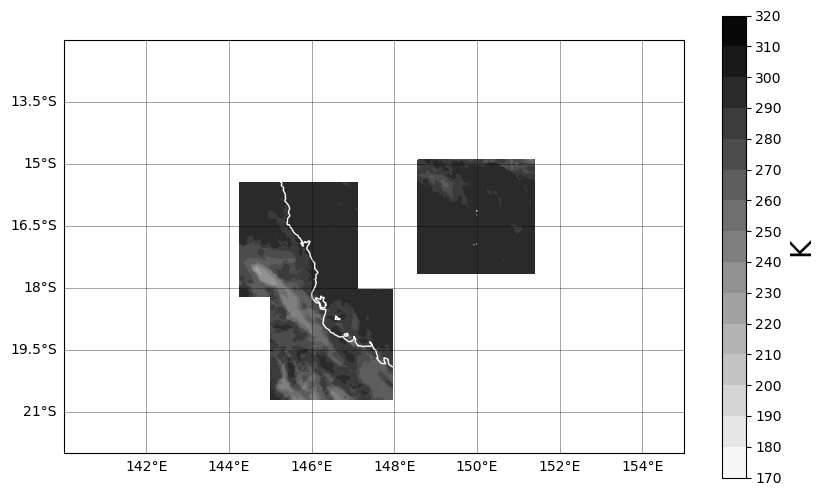

In [216]:
#### create snapshot latlong plot
fig = plt.figure(1, figsize=[10,6])
fig.patch.set_facecolor('white')
ax = plt.axes(projection=ccrs.PlateCarree())
levels = [170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320]
cs = ax.contourf(xi[140:194,100:160],yi[140:194,100:160],BTD[140:194,100:160],levels=levels,cmap="binary") #townsville
cs = ax.contourf(xi[88:144,85:143],yi[88:144,85:143],BTD[88:144,85:143],levels=levels,cmap="binary") #cairns
cs = ax.contourf(xi[77:133,171:229],yi[77:133,171:229],BTD[77:133,171:229],levels=levels,cmap="binary") #willis
cbar = plt.colorbar(cs,aspect=20,orientation='vertical',ax=ax,
                    ticks=[170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320])
cbar.set_label('K',fontsize=20) 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='black', alpha=0.5, linestyle='-')
gl.top_labels = False
gl.right_labels = False
ax.set_xlim(140,155)
ax.set_ylim(-22,-12)
ax.coastlines(color="white")
# fn = os.path.basename(files2016[0]).split('/')[-1]
# ax.set_title(fn[20:32],fontsize=20,pad=2);
xi[77:133,171:229] #-18.165955,-15.468018,144.27374,147.09222) #cairns
#-17.636353,-14.938416,148.55927,151.36993) #willis island


In [ ]:
files = files2021+files2022
len(files2021)

In [ ]:
def generate_him8_snapshots(file_list):
    file_list.sort()
    for file in np.arange(0,len(file_list)):
        ds = xr.open_dataset(file_list[file],engine="h5netcdf") 
        
        ch13bt_data = ds['ACHA_mode_8_cloud_top_temperature'][1500:2300,2500:3500].values#[1700:2300,2800:3500].values #for valid points=[:3299,33:4124]; [1910:2170,2800:3400].values#
        ch13bt_reshape = ch13bt_data.reshape(800000)
        ch13bt_reshape[np.isnan(ch13bt_reshape)] = 0    
        lon2d = ds['pixel_longitude'][1500:2300,2500:3500].values
        lon1d = lon2d.reshape(800000 )
        lon1d[np.isnan(lon1d)] = 0
        lat2d = ds['pixel_latitude'][1500:2300,2500:3500].values
        lat1d = lat2d.reshape(800000 )
        lat1d[np.isnan(lat1d)] = 0

        # create meshgrid for interpolation
        res = 0.1 #0.18
        grid_x = np.arange(140, 154, res)#154, res)
        grid_y = np.arange(-22, -10, res)#-22, -11, res)
        grid_y = np.flipud(grid_y)
        xi,yi = np.meshgrid(grid_x,grid_y)

        # interpolate channel 13 brightness temperature values onto x,y grid
        CTP = griddata((lon1d,lat1d), ch13bt_reshape, (xi, yi), method='nearest') ##### return= CTP[lat:lon]   

        # create snapshot latlong plot
        fig = plt.figure(figsize=[10,6])
        fig.patch.set_facecolor('white')
        ax = plt.axes(projection=ccrs.PlateCarree())
        levels = [170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320]
        cs = plt.contourf(xi,yi,CTP,levels=levels,cmap="binary")
        cbar = plt.colorbar(cs,aspect=20,orientation='vertical',
                    ticks=[170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320])
        cbar.set_label('K',fontsize=20) 
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='black', alpha=0.5, linestyle='-')
        gl.top_labels = False
        gl.right_labels = False
        ax.set_xlim(140,152)
        ax.set_ylim(-22,-10)
        ax.coastlines(color="white")
        fn = os.path.basename(file_list[file]).split('/')[-1]
        print(fn[20:32])
        plt.title(fn[20:32],fontsize=20,pad=2)
        plt.savefig("/home/563/ac9768/plots/him8/"+fn[20:32]+".png")  # You can change the file extension to specify the format
        plt.close(fig)  # Close the figure to prevent overlay
    return

In [ ]:
%%time
generate_him8_snapshots(files2016[0:24])

In [ ]:
import glob
from PIL import Image

In [ ]:
# filepaths
fp_in = "/home/563/ac9768/plots/him8/*.png"
fp_out = "/home/563/ac9768/plots/him8/gif.gif"

In [ ]:
# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=400, loop=1)